In [1]:
# Import Statements
import keras
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
import numpy as np
import pandas as pd
from collections import defaultdict
import re


import sys
import os

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, merge, Dropout
from keras.models import Model

MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 200000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4868330521882934229
]


**Data Pre-processing**

In [2]:
def clean_str(string):
    """
    Cleaning of dataset
    """
    string = re.sub(r"\\", "", string)    
    string = re.sub(r"\'", "", string)    
    string = re.sub(r"\"", "", string)    
    return string.strip().lower()

In [3]:
dataset = pd.read_csv('/content/drive/MyDrive/NLP Project/dataset.csv')

In [4]:
dataset.head()

,Head,Body,Label,Features
0,food snack selection popular greek dishes,underwhelmed main courses tables sometimes har...,0,5.0 4.435897435897436 39 4.0 4.009523809523809...
1,little place soho wonderful,price shocked small serving soho staff little ...,0,3.0 3.0 1 4.0 4.0095238095238095 210 4 3
2,ordered lunch snack last friday,added regular company lunch list everyone enjo...,0,4.0 4.0 2 4.0 4.0095238095238095 210 3 4
3,beautiful quaint little restaurant pretty street,heard reviews lamb sandwich try happy every si...,0,4.0 4.0 1 4.0 4.0095238095238095 210 7 4
4,snack great place casual sit lunch especially ...,avgolemono soup lemony perfection butter bean ...,0,4.0 3.6 5 4.0 4.0095238095238095 210 6 4


In [5]:
dataset=dataset.sort_values(by=['Label'],ascending=True)

In [6]:
dataset=dataset[0:50000]

In [7]:
dataset.groupby('Label').count()

,Head,Body,Features
Label,,,
0,24903,24903,24903
1,25097,25097,25097


In [8]:
texts = []
labels = []

for i in range(len(dataset)):
    text1 = dataset['Head'].iloc[i]
    text2 = dataset['Body'].iloc[i]
    text = str(text1) +""+ str(text2)
    texts.append(text)
    labels.append(dataset['Label'].iloc[i])
    
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index

In [9]:
'''
for l in range(len(labels)):
  if labels[l]==-1:
    labels[l]=0 #change fake label to 0
'''

'\nfor l in range(len(labels)):\n  if labels[l]==-1:\n    labels[l]=0 #change fake label to 0\n'

In [10]:
# Pad input sequences
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels1 = to_categorical(np.asarray(labels),num_classes = 2)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels1.shape)

Shape of data tensor: (50000, 1000)
Shape of label tensor: (50000, 2)


In [11]:
# Train test validation Split
from sklearn.model_selection import train_test_split
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels1[indices]
x_train, x_test_all, y_train, y_test_all = train_test_split( data, labels, test_size=0.20, random_state=7)
x_test, x_val, y_test, y_val = train_test_split( x_test_all, y_test_all, test_size=0.50, random_state=7)
print('Size of train, validation, test:', len(y_train), len(y_val), len(y_test))

print('real & fake reviews in train,valt,test:')
print(y_train.sum(axis=0))
print(y_val.sum(axis=0))
print(y_test.sum(axis=0))

Size of train, validation, test: 40000 5000 5000
real & fake reviews in train,valt,test:
[19994. 20006.]
[2474. 2526.]
[2435. 2565.]


In [12]:
from keras.models import Sequential
from keras.layers.convolutional import Conv3D
from keras.layers.convolutional_recurrent import ConvLSTM2D
from keras.layers.normalization import BatchNormalization
import numpy as np
from matplotlib import pyplot as plt
from keras.layers import Dense, Embedding, LSTM

%matplotlib inline

In [13]:
#Using Pre-trained word embeddings
GLOVE_DIR = "/content/drive/MyDrive/NLP Project" 
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove.' % len(embeddings_index))

embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH)

Total 400000 word vectors in Glove.


In [14]:
embedding_vecor_length = 32
modell = Sequential()
modell.add(embedding_layer)
modell.add(Dropout(0.2))
modell.add(Conv1D(filters=32, kernel_size=5, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
modell.add(MaxPooling1D(pool_size=2))
modell.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
modell.add(BatchNormalization())
modell.add(Dense(256, activation='relu'))
modell.add(Dense(128, activation='relu'))
modell.add(Dense(64, activation='relu'))
modell.add(Dense(2, activation='softmax'))
modell.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(modell.summary())
#modell.load_weights('/content/drive/MyDrive/NLP Project/lstm_undersampled_1.h5')
modell.fit(x_train, y_train, epochs=5, batch_size=64)

modell.save('/content/drive/MyDrive/NLP Project/lstm_cnn_model.h5')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 1000, 100)         10156800  
_________________________________________________________________
dropout (Dropout)            (None, 1000, 100)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1000, 32)          16032     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 500, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 500, 64)           6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 250, 64)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               6

Correct predictions: 3574.0
Total number of test examples: 5000
Accuracy of model1:  0.7148
f1_score(macro): 0.7146516645212848


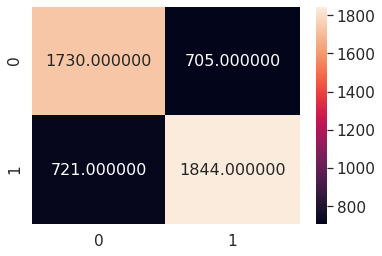

In [18]:
#modell.load_weights('/content/drive/MyDrive/NLP Project/lstm_cnn_model_1.h5')
import matplotlib.pyplot as plt
import seaborn as sns
test_preds = modell.predict(x_test)
test_preds = np.round(test_preds)
correct_predictions = float(sum(test_preds == y_test)[0])
print("Correct predictions:", correct_predictions)
print("Total number of test examples:", len(y_test))
print("Accuracy of model1: ", correct_predictions/float(len(y_test)))
from sklearn.metrics import  f1_score
print("f1_score(macro): {}".format(f1_score(y_test, test_preds, average="macro")))
# Creating the Confusion Matrix
from sklearn.metrics import confusion_matrix
x_pred = modell.predict(x_test)
x_pred = np.round(x_pred)
x_pred = x_pred.argmax(1)
y_test_s = y_test.argmax(1)
cm = confusion_matrix(y_test_s, x_pred)
sns.set(font_scale=1.4)#for label size
sns.heatmap(cm,annot=True,annot_kws={"size": 16},fmt='1f')# font size